In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data=pd.read_csv('iris1.csv')
data.isnull().sum()

sepal_len    0
sepal_wid    0
petal_len    0
petal_wid    0
class        0
dtype: int64

In [2]:
print(data.shape)
print(data.info())

(150, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sepal_len  150 non-null    float64
 1   sepal_wid  150 non-null    float64
 2   petal_len  150 non-null    float64
 3   petal_wid  150 non-null    float64
 4   class      150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


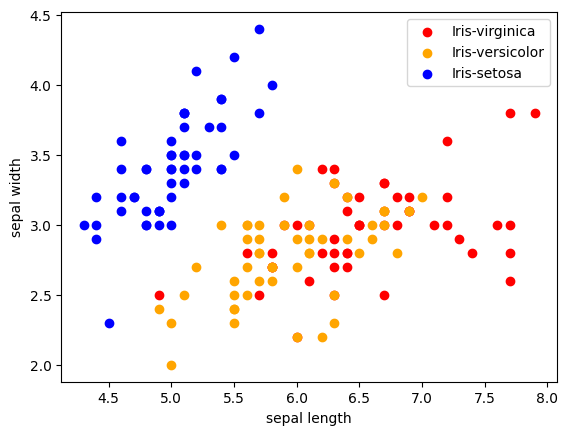

In [3]:
# scatter plot
colors=['red' , 'orange', 'blue']
species=['Iris-virginica','Iris-versicolor' ,'Iris-setosa']

for i in range(3):
    x=data[data['class'] ==species[i]]
    plt.scatter(x['sepal_len'], x['sepal_wid'] , c=colors[i] , label= species[i])
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [4]:
y = data['class']
y

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: class, Length: 150, dtype: object

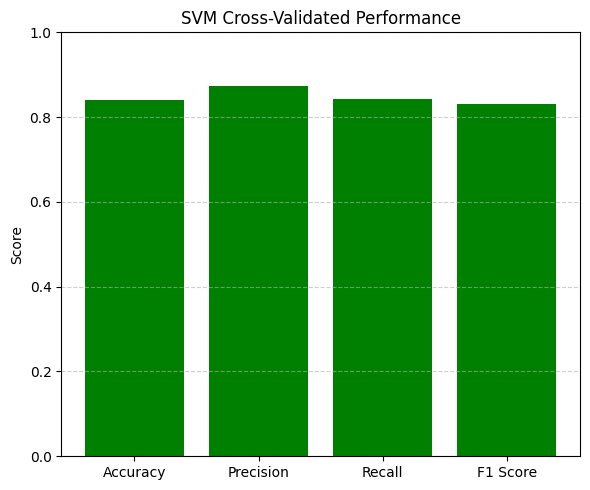

Accuracy: 0.84, Precision: 0.87, Recall: 0.84, F1 Score: 0.83


In [3]:
# SVM
import pandas as pd
import numpy as np

label_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
data['class'] = data['class'].map(label_map)

# Step 2: Features and target
features = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid']
X = data[features].values
y = data['class'].values

# Step 3: Manual normalization
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0) + 1e-8
X = (X - X_mean) / X_std

# Step 4: Linear SVM class
class LinearSVM:
    def __init__(self, lr=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.lr * y[idx]

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# Step 5: One-vs-Rest
def train_ovr(X_train, y_train):
    models = {}
    classes = np.unique(y_train)
    for c in classes:
        binary_y = np.where(y_train == c, 1, -1)
        clf = LinearSVM()
        clf.fit(X_train, binary_y)
        models[c] = clf
    return models

def predict_ovr(models, X_test):
    predictions = []
    for x in X_test:
        scores = {label: np.dot(model.w, x) + model.b for label, model in models.items()}
        pred = max(scores, key=scores.get)
        predictions.append(pred)
    return np.array(predictions)

# Step 6: Evaluation metrics
def evaluate(y_true, y_pred):
    labels = np.unique(y_true)
    accuracy = np.mean(y_true == y_pred)

    precision_list, recall_list, f1_list = [], [], []
    for label in labels:
        TP = sum((y_true == label) & (y_pred == label))
        FP = sum((y_true != label) & (y_pred == label))
        FN = sum((y_true == label) & (y_pred != label))

        precision = TP / (TP + FP + 1e-6)
        recall = TP / (TP + FN + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    precision = np.mean(precision_list)
    recall = np.mean(recall_list)
    f1 = np.mean(f1_list)

    return accuracy, precision, recall, f1

# ... (all your previous code unchanged) ...

def cross_validate(X, y, k=5):
    fold_size = len(X) // k
    indices = np.arange(len(X))
    np.random.seed(42)
    np.random.shuffle(indices)

    accs, pres, recs, f1s = [], [], [], []

    for i in range(k):
        test_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.setdiff1d(indices, test_idx)

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        models = train_ovr(X_train, y_train)
        y_pred = predict_ovr(models, X_test)

        acc, prec, rec, f1 = evaluate(y_test, y_pred)

        accs.append(acc)
        pres.append(prec)
        recs.append(rec)
        f1s.append(f1)

    return np.mean(accs), np.mean(pres), np.mean(recs), np.mean(f1s)

# Run cross-validation and get metrics
acc, pres, rec_svm, f1_svm = cross_validate(X, y, k=5)

import matplotlib.pyplot as plt
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
svm_scores = [acc, pres, rec_svm, f1_svm]

plt.figure(figsize=(6, 5))
plt.bar(labels, svm_scores, color='green')
plt.title('SVM Cross-Validated Performance')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(f"Accuracy: {acc:.2f}, Precision: {pres:.2f}, Recall: {rec_svm:.2f}, F1 Score: {f1_svm:.2f}")

